# Getting Started: Executing a Dummy Experiment Run

This tutorial gently guides you through your first end-to-end run with palaestrAI. Here, you will learn how an experiment run file looks like, how to execute it, and how to query the store for data. We will stay only within palaestrAI core and not import any hARL agent, or use an extended palaestrAI environment. As such, the agents will perform only random actions in a dummy environment. That might not look super exciting, but then again, its good to start with baby steps and train the mighty agents later on...!

This tutorial will call the palaestrAI API directly from the notebook. The command-line interface (CLI) does exactly that under the hood, too: There is no difference in the general usage or the layout of the experiment run files. But with the Juypter notebook, we can have everything neatly in one place.

So sit back and follow us through your first experiment run... Have a lot of fun!

## Imports

Let's start by importing necessary modules. This will be what we need for palaestrAI, namely the entrypoint, the runtime config, and the database access stuff:

In [1]:
import palaestrai        # Will provide palaestrai.exectue
import palaestrai.core   # RuntimeConfig
import palaestrai.store  # store.Session for database connectivity
import palaestrai.store.database_util
import palaestrai.store.database_model as paldb

The typical data science analysis toolstack uses *pandas* and *matplotlib*, so let's import those, too. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

*jsonpickle* we will need to inspect the reward information objects later on. Here, we also need to use the jsonpickle extension for numpy:

In [3]:
import jsonpickle
import jsonpickle.ext.numpy as jsonpickle_numpy
jsonpickle_numpy.register_handlers()

There are also some of the usual suspects from Python's standard library, which we'll import here without further comment:

In [4]:
import io
import os
import pprint
import tempfile
from pathlib import Path

## Experiment Run Document

Everything palaestrAI does depends on its configuration, or rather, *experiments*. When you do real design of experiments, you first create an *experiment* document, in which you define strategies for sampling your factors. Each sample is an *experiment run*, which will be executed by palaestrAI. We won't do the full DoE dance here, but rather provide an experiment run document directly.

Experiments and experiment runs have **unique names** (`uid`). When they're not given, they are auto-generated, but usually the user wants to set them in order to find them in the store later on. Choosing a good name might seem hard (it isn't, any string will do); being forced to choose a *unique* name might seem an unecessary constraint. However, it isn't: Each experiment run must be repeatable, i.e., always have the same result, no matter how often it is run. A change in an experiment run definition can yield different results. Therefore, each experiment run is unique—and thus should be its name, too. We will define the experiment run name as a separate variable so that we don't have to remember it later on when we query the store:

In [5]:
experiment_run_name = "Tutorial Experiment Run"

Experiment (run) documents also have a **version**. It serves as a discriminator to catch semantic changes in the document. It is an additional safeguard and emits a log message, but not a stopgap. 

For this tutorial, we set the document's version to palaestrAI's version. That is okay here since we need to keep this documented up-to-date in any case. When experiment runs are archived, the version number (and its immutability!) become more important.

In [6]:
experiment_run_version = "3.4"

And now to the document itself. Apart from the `uid`, the `version`, and the random seed (`seed`), it provides the configuration of the experiment run. Experiment runs have *phases*, so the most important key here is the experiment `schedule`.

A **schedule** defines the phases of an experiment run. A phase comprises environments, agents, simulation parameters such as the termination condition, as well as general configuration flags. Schedule configurations are cascading: Values defined in the previous phase are applied to following phases, too, unless they are explicitly overwritten.

In our example, we have three phases in our schedule. The first phase trains only one agent, the second trains two in the same environment, and finally, there is a third phase as testing stage.

(*Please note* that we're using an f-string here, and hence the YAML dict `{}` becomes `{{}}`.)

In [7]:
experiment_run_document = f"""
uid: "{experiment_run_name}"
seed: 47  # Not quite Star Trek, but...
version: {experiment_run_version}
schedule:  # The schedule for this run; it is a list
  - phase_0:
      environments:  # Definition of the environments for this phase
        - environment:
            name: palaestrai.environment.dummy_environment:DummyEnvironment
            uid: denv
            params: {{ }}
      agents:  # Definiton of agents for this phase
        - name: mighty_defender
          brain:
            name: palaestrai.agent.dummy_brain:DummyBrain
            params: {{ }}
          muscle:
            name: palaestrai.agent.dummy_muscle:DummyMuscle
            params: {{ }}
          objective:
            name: palaestrai.agent.dummy_objective:DummyObjective
            params: {{"params": 1}}
          sensors: [denv.0, denv.1, denv.2, denv.3, denv.4]
          actuators: [denv.0, denv.1, denv.2, denv.3, denv.4]
      simulation:  # Definition of the simulation controller for this phase
        name: palaestrai.simulation:VanillaSimController
        conditions:
        - name: palaestrai.simulation:VanillaSimControllerTerminationCondition
          params: {{ }}
      phase_config:  # Additional config for this phase
        mode: train
        worker: 1
        episodes: 5 
  - phase_1:  # Name of the current phase. Can be any user-chosen name
      agents:  # Definiton of agents for this phase
        - name: mighty_defender
          brain:
            name: palaestrai.agent.dummy_brain:DummyBrain
            params: {{ }}
          muscle:
            name: palaestrai.agent.dummy_muscle:DummyMuscle
            params: {{ }}
          objective:
            name: palaestrai.agent.dummy_objective:DummyObjective
            params: {{"params": 1}}
          sensors: [denv.0, denv.1, denv.2, denv.3, denv.4]
          actuators: [denv.0, denv.1, denv.2, denv.3, denv.4]
        - name: evil_attacker
          brain:
            name: palaestrai.agent.dummy_brain:DummyBrain
            params: {{ }}
          muscle:
            name: palaestrai.agent.dummy_muscle:DummyMuscle
            params: {{ }}
          objective:
            name: palaestrai.agent.dummy_objective:DummyObjective
            params: {{"params": 1}}
          sensors: [denv.5, denv.6, denv.7, denv.8, denv.9]
          actuators: [denv.5, denv.6, denv.7, denv.8, denv.9]
      simulation:  # Definition of the simulation controller for this phase
        name: palaestrai.simulation:VanillaSimController
        conditions:
        - name: palaestrai.simulation:VanillaSimControllerTerminationCondition
          params: {{ }}
      phase_config:  # Additional config for this phase
        mode: train
        worker: 1
        episodes: 2
  - phase_2:  # Definition of the second phase. Keeps every information
              # from the first except for those keys that are redefined
              # here.
      phase_config:  
        mode: test
        episodes: 3
run_config:  # Not a runTIME config
  condition:       
    name: palaestrai.experiment:VanillaRunGovernorTerminationCondition
    params: {{ }}
"""

## Runtime Config

With the experiment run neatly defined, there is something else that defines how palaestrAI behaves: Its runtime config. It has nothing to do with an experiment run, but defines the behavior of palaestrAI on a certain machine. This includes log levels or the URI defining how to connect to the database. Usually, one does not touch it once the framework is installed.

In this case, we're playing it safe and provide some sane defaults that are only relevant for the scope of this notebook. For example, we'll resort to using SQLite in a temporary directory instead of PostgreSQL + TimescaleDB (speed is not of importance here).

Let's create the database in a temporary location:

In [8]:
store_dir = tempfile.TemporaryDirectory()
store_dir

<TemporaryDirectory '/tmp/tmpciw4hcj1'>

In [9]:
runtime_config = palaestrai.core.RuntimeConfig()
runtime_config.reset()
runtime_config.load(
    {
        "store_uri": "sqlite:///%s/palaestrai.db" % store_dir.name,
        "executor_bus_port": 4747,
        "logger_port": 4748,
    }
)
pprint.pprint(runtime_config.to_dict())

{'executor_bus_port': 4747,
 'logger_port': 4748,
 'logging': {'filters': {'debug_filter': {'()': 'palaestrai.core.runtime_config.DebugLogFilter'}},
             'formatters': {'debug': {'format': '%(asctime)s '
                                                '%(name)s[%(process)d]: '
                                                '%(levelname)s - %(message)s '
                                                '(%(module)s.%(funcName)s in '
                                                '%(filename)s:%(lineno)d)'},
                            'simple': {'format': '%(asctime)s '
                                                 '%(name)s[%(process)d]: '
                                                 '%(levelname)s - '
                                                 '%(message)s'}},
             'handlers': {'console': {'class': 'logging.StreamHandler',
                                      'formatter': 'simple',
                                      'level': 'INFO',
                  

The nice thing about the `RuntimeConfig` is that it is a singleton available everywhere in the framework. So whatever we set here pertains throughout the run.

## Database Initialization

Since we've opted to start fresh with a new SQLite database in a temporary directory, we will have to create and initialize it. Usually, one does this once (e.g., from the CLI with `palaestrai database-create`) and is then done with it, but in this case we do it every time we run the notebook—it is a one-shot tutorial, after all. :-)

Luckily, palaestrAI has just the function we need to do it for us:

In [10]:
palaestrai.store.database_util.setup_database(runtime_config.store_uri)

Could not create extension timescaledb and create hypertables: (sqlite3.OperationalError) near "EXTENSION": syntax error
[SQL: CREATE EXTENSION IF NOT EXISTS timescaledb CASCADE;]
(Background on this error at: https://sqlalche.me/e/14/e3q8). Your database setup might lead to noticeable slowdowns with larger experiment runs. Please upgrade to PostgreSQL with TimescaleDB for the best performance.


You will see a warning regarding the TimescaleDB extension. That is okay and just a warning. Since we're not running a big, sophisticated experiment, we can live with a bit of a performance penality.

## Experiment Run Execution

Next up: Actually executing the experiment run! It just consists of one line: A call to `palaestrai.execute()`. This method can cope with three types of parameters:

1. An `ExperimentRun` object. Nice in cases one has already loaded it (e.g., de-serialized it).
2. A `str`. `palaestrAI.execute()` interprets this as a path to a file—one of the most common use cases.
3. A `TextIO` object: Any stream that delivers text. Useful when the experiment run document is not yet deserialized, and exactly what we need.

To turn a `str` into a `TextIO`, we simply wrap it into a `StringIO` object. Make it so!

In [11]:
rc = palaestrai.execute(io.StringIO(experiment_run_document))

The execution should yield no errors (and no warnings, too).

In [12]:
assert rc[1].name == "EXITED"

## Querying the Store

Let's get a custom session to the database first:

In [13]:
dbh = palaestrai.store.Session()

palaestrAI has no special database access features, only nice object-relational mapper (ORM) bindings provided by SQLAlchemy. Which means that we can use all the nice magic SQLAlchemy gives us. So let's first import it:

In [14]:
import sqlalchemy as sa

Do you remember the name of our experiment run? We can now use it to look it up. Therefore, we first create a query using `sqlalchemy.select`, which we then execute.

In [15]:
q = sa.select(paldb.ExperimentRun).where(paldb.ExperimentRun.uid == experiment_run_name)
str(q)

'SELECT experiment_runs.document, experiment_runs.document_json, experiment_runs.id, experiment_runs.uid, experiment_runs.experiment_id \nFROM experiment_runs \nWHERE experiment_runs.uid = :uid_1'

palaestrAI ensures through the `uid` that each experiment run is stored only once in the database. `one()` not only retrieves only one element from the query, it also raises an exception if there's no or more than one row in the result set. Thus:

In [16]:
result = dbh.execute(q).one()
experiment_run_record = result[paldb.ExperimentRun]
experiment_run_record.id, experiment_run_record.uid

(1, 'Tutorial Experiment Run')

…yes, that's us. 

No matter how often an experiment run is executed, there will be only one entry for the same UID in the table. But many more instances will exist. Here, since we ran it only once, we will also see only one experiment run instance.

Through the SQLAlechemy ORM, we can access the experiment run instances directly:

In [17]:
experiment_run_record.experiment_run_instances

Would we run execute the run again, we'd see two entries in the list here:

In [18]:
rc = palaestrai.execute(io.StringIO(experiment_run_document))
assert rc[1].name == "EXITED"

In [19]:
dbh.refresh(experiment_run_record)
experiment_run_record.experiment_run_instances

In [20]:
assert len(experiment_run_record.experiment_run_instances) > 1

Now let's focus on the run phases. Each instance will have several of them—three, to be precise. Remember our experiment run document? We have three, so lets find them in the database:

In [21]:
experiment_run_record.experiment_run_instances[0].experiment_run_phases

In [22]:
assert len(experiment_run_record.experiment_run_instances[0].experiment_run_phases) == 3

Next up: Who did participate in this run phase? We can define participants for each run phase separately. In our experiment run document, we decided that first one agent may train on its own, then we have two agents train together, and finally a test phase for both. So that is what we want to see now.

However, simply exploring the ORM is not really fun for showing it in a Jupyter notebook. Thankfully, SQLAlchemy and pandas interface nicely: We can construct a query in SQLAlchemy with our ORM and than end it over to pandas to construct a dataframe out of it:

In [23]:
pd.read_sql(
    sa.select(paldb.Agent)
    .where(
        paldb.Agent.experiment_run_phase_id.in_(
            phase.id for phase in experiment_run_record.experiment_run_instances[0].experiment_run_phases
        )
    ),
    dbh.bind
)

configuration  id  \
0  {'name': 'mighty_defender', 'brain': {'name': ...   1   
1  {'name': 'mighty_defender', 'brain': {'name': ...   2   
2  {'name': 'evil_attacker', 'brain': {'name': 'p...   3   
3  {'name': 'mighty_defender', 'brain': {'name': ...   4   
4  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   

                                                 uid             name  \
0  AgentConductor-e9462444-5cca-4af9-b85b-d4d7c48...  mighty_defender   
1  AgentConductor-b94661bc-732e-42de-9052-4507b73...  mighty_defender   
2  AgentConductor-e9453b5d-c37d-4d68-8342-ba0ccce...    evil_attacker   
3  AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
4  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   

                                             muscles  experiment_run_phase_id  
0  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:7aba1b...                        1  
1  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:d1f32c...                        2  
2  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a375b4...                        2  
3  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...                        3  
4  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...                        3

Okay, now that we have explored many things, let's find out how good our agents were! Let us start by looking at how well the first agent trained when it was alone. Each agent gets a new ID when it enters a new experiment run phase, regardless of whether its the same agent than before or a new one. (The discriminating element is the agent's name.)

We first need the ID of the first experiment run phase:

In [24]:
run_phase_id = min(phase.id for phase in experiment_run_record.experiment_run_instances[0].experiment_run_phases)
run_phase_id

1

Okay, which agent is it?

In [25]:
agent_record = dbh.execute(
    sa.select(paldb.Agent)
    .where(paldb.Agent.experiment_run_phase_id==run_phase_id)
).one()[paldb.Agent]
assert agent_record.name == 'mighty_defender'
agent_record.id, agent_record.name

(1, 'mighty_defender')

In [26]:
actions = pd.read_sql(
    sa.select(paldb.MuscleAction).where(paldb.MuscleAction.agent_id==agent_record.id),
    dbh.bind
)
actions

simtimes                                    sensor_readings  \
0   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
1   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
2   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
3   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
4   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
5   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
6   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
7   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
8   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
9   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
10  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
11              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
12  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
13  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
14  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
15  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
16  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
17  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
18  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
19  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
20  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
21  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
22  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
23              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
24  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
25  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
26  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
27  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
28  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
29  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
30  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
31  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
32  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
33  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
34  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
35              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
36  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
37  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
38  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
39  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
40  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
41  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
42  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
43  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
44  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
45  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
46  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
47              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
48  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
49  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
50  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
51  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
52  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
53  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform..

Okay, but how do we get rewards out of this? The `rewards` column contains a list of `RewardInformation` objects. In our case, we know that there will ever be only one (more than one is a special case). We also know that there will always be a `float`. The knowledge about this comes from our knowledge of the reward, i.e., it is really domain knowledge that an experimenter will have.

At this point, we need to modify the dataframe a bit. We have to call `jsonpickle.loads()` to get the object, and then extract the reward out of it. `DataFrame.apply()` solves us well here. In order to make it more readable, we provide a function for this.

In [27]:
def unpack_reward(x):
    return float(x[0]["reward_value"]) if x else 0.0

actions.rewards = actions.rewards.apply(lambda x: unpack_reward(x))
actions

simtimes                                    sensor_readings  \
0   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
1   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
2   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
3   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
4   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
5   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
6   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
7   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
8   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
9   {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
10  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
11              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
12  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
13  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
14  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
15  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
16  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
17  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
18  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
19  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
20  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
21  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
22  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
23              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
24  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
25  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
26  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
27  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
28  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
29  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
30  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
31  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
32  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
33  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
34  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
35              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
36  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
37  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
38  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
39  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
40  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
41  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
42  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
43  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
44  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
45  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
46  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
47              {}  [{'py/object': 'palaestrai.agent.sensor_inform...   
48  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
49  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
50  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
51  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
52  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform...   
53  {'denv': None}  [{'py/object': 'palaestrai.agent.sensor_inform..

Plotting is relatively easy now, as pandas already provides us with everything we need.

<AxesSubplot:xlabel='id', ylabel='rewards'>

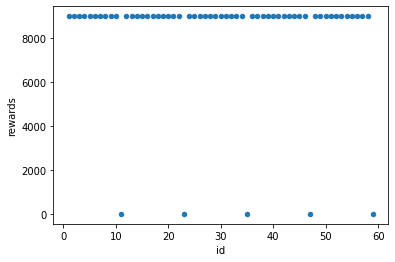

In [28]:
actions.plot(x="id", y="rewards", kind="scatter")

Okay, but if we want to compare the agents' performance during the testing phase? First we need to find out what agents participated in the last experiment run phase. So let's return to the experiment run phases table:

In [29]:
experiment_run_phases = pd.read_sql(
    sa.select(paldb.Agent)
    .where(
        paldb.Agent.experiment_run_phase_id.in_(
            phase.id for phase in experiment_run_record.experiment_run_instances[0].experiment_run_phases
        )
    )
    .order_by(paldb.Agent.experiment_run_phase_id.desc()),
    dbh.bind
)
experiment_run_phases

configuration  id  \
0  {'name': 'mighty_defender', 'brain': {'name': ...   4   
1  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
2  {'name': 'mighty_defender', 'brain': {'name': ...   2   
3  {'name': 'evil_attacker', 'brain': {'name': 'p...   3   
4  {'name': 'mighty_defender', 'brain': {'name': ...   1   

                                                 uid             name  \
0  AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
1  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
2  AgentConductor-b94661bc-732e-42de-9052-4507b73...  mighty_defender   
3  AgentConductor-e9453b5d-c37d-4d68-8342-ba0ccce...    evil_attacker   
4  AgentConductor-e9462444-5cca-4af9-b85b-d4d7c48...  mighty_defender   

                                             muscles  experiment_run_phase_id  
0  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...                        3  
1  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...                        3  
2  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:d1f32c...                        2  
3  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a375b4...                        2  
4  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:7aba1b...                        1

Okay, the top two rows are the ones we want to look at.

In [30]:
muscle_actions = pd.read_sql(
    sa.select(paldb.Agent, paldb.MuscleAction)
    .join(paldb.Agent.muscle_actions)
    .where(paldb.Agent.experiment_run_phase_id.in_(experiment_run_phases.experiment_run_phase_id[0:2])),
    dbh.bind
)
assert len(muscle_actions) > 2
muscle_actions

configuration  id  \
0   {'name': 'mighty_defender', 'brain': {'name': ...   4   
1   {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
2   {'name': 'mighty_defender', 'brain': {'name': ...   4   
3   {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
4   {'name': 'mighty_defender', 'brain': {'name': ...   4   
..                                                ...  ..   
65  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
66  {'name': 'mighty_defender', 'brain': {'name': ...   4   
67  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
68  {'name': 'mighty_defender', 'brain': {'name': ...   4   
69  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   

                                                  uid             name  \
0   AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
1   AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
2   AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
3   AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
4   AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
..                                                ...              ...   
65  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
66  AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
67  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
68  AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
69  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   

                                              muscles  \
0   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
1   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
2   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
3   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
4   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
..                                                ...   
65  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
66  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
67  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
68  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
69  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   

    experiment_run_phase_id        simtimes  \
0                         3  {'denv': None}   
1                         3  {'denv': None}   
2                         3  {'denv': None}   
3                         3  {'denv': None}   
4                         3  {'denv': None}   
..                      ...             ...   
65                        3  {'denv': None}   
66                        3  {'denv': None}   
67                        3  {'denv': None}   
68                        3  {'denv': None}   
69                        3  {'denv': None}   

                                      sensor_readings  \
0   [{'py/object': 'palaestrai.agent.sensor_inform...   
1   [{'py/object': 'palaestrai.agent.sensor_inform...   
2   [{'py/object': 'palaestrai.agent.sensor_inform...   
3   [{'py/object': 'palaestrai.agent.sensor_inform...   
4   [{'py/object': 'palaestrai.agent.sensor_inform...   
..                                                ...   
65  [{'py/object': 'palaestrai.agent.sensor_inform...   
66  [{'py/object': 'palaestrai.agent.sensor_inform...   
67  [{'py/object': 'palaestrai.agent.sensor_inform...   
68  [{'py/object': 'palaestrai.agent.sensor_inform...   
69  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                   actuator_setpoints  \
0   [{'py/object': 'palaestrai.agent.actuator_info...   
1   [{'py/object': 'palaestrai.agent.actuator_info...   
2   [{'py/object': 'palaestrai.agent.actuator_info...   
3   [{'py/object': 'palaestrai.agent.actuator_info...   
4   [{'py/object': 'palaestrai.agent.actuator_info...   
..                                                ...   
65  [{'py/object': 'palaestrai.agent.actuator_info...   
66  [{'py/object': 'palaest

Let's do the reward conversion dance:

In [31]:
muscle_actions.rewards = muscle_actions.rewards.apply(lambda x: unpack_reward(x))
muscle_actions

configuration  id  \
0   {'name': 'mighty_defender', 'brain': {'name': ...   4   
1   {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
2   {'name': 'mighty_defender', 'brain': {'name': ...   4   
3   {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
4   {'name': 'mighty_defender', 'brain': {'name': ...   4   
..                                                ...  ..   
65  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
66  {'name': 'mighty_defender', 'brain': {'name': ...   4   
67  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   
68  {'name': 'mighty_defender', 'brain': {'name': ...   4   
69  {'name': 'evil_attacker', 'brain': {'name': 'p...   5   

                                                  uid             name  \
0   AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
1   AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
2   AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
3   AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
4   AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
..                                                ...              ...   
65  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
66  AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
67  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   
68  AgentConductor-fb13655c-a226-40fb-9024-9561197...  mighty_defender   
69  AgentConductor-823fccf0-84a3-4c49-80d8-f4a89ba...    evil_attacker   

                                              muscles  \
0   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
1   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
2   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
3   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
4   [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
..                                                ...   
65  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
66  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
67  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   
68  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:a48811...   
69  [6d5d6ae0-63c5-4dcd-9487-e63408070dfd_A:02a6ab...   

    experiment_run_phase_id        simtimes  \
0                         3  {'denv': None}   
1                         3  {'denv': None}   
2                         3  {'denv': None}   
3                         3  {'denv': None}   
4                         3  {'denv': None}   
..                      ...             ...   
65                        3  {'denv': None}   
66                        3  {'denv': None}   
67                        3  {'denv': None}   
68                        3  {'denv': None}   
69                        3  {'denv': None}   

                                      sensor_readings  \
0   [{'py/object': 'palaestrai.agent.sensor_inform...   
1   [{'py/object': 'palaestrai.agent.sensor_inform...   
2   [{'py/object': 'palaestrai.agent.sensor_inform...   
3   [{'py/object': 'palaestrai.agent.sensor_inform...   
4   [{'py/object': 'palaestrai.agent.sensor_inform...   
..                                                ...   
65  [{'py/object': 'palaestrai.agent.sensor_inform...   
66  [{'py/object': 'palaestrai.agent.sensor_inform...   
67  [{'py/object': 'palaestrai.agent.sensor_inform...   
68  [{'py/object': 'palaestrai.agent.sensor_inform...   
69  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                   actuator_setpoints  rewards  id_1  \
0   [{'py/object': 'palaestrai.agent.actuator_info...   9000.0   106   
1   [{'py/object': 'palaestrai.agent.actuator_info...   9000.0   107   
2   [{'py/object': 'palaestrai.agent.actuator_info...   9000.0   108   
3   [{'py/object': 'palaestrai.agent.actuator_info...   9000.0   109   
4   [{'py/object': 'palaestrai.agent.actuator_info...   9000.0   110   
..                                                .

The table contains rewards, alternating, for both agents. You can see that from the `simtime_ticks` entry as well the `name` column. So let's plot them—it's easy now:

<AxesSubplot:>

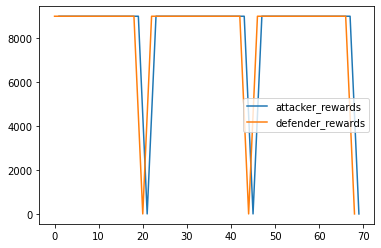

In [32]:
defender_actions = muscle_actions[muscle_actions.name=="mighty_defender"][["rewards"]].rename(columns={"rewards": "defender_rewards"})
attacker_actions = muscle_actions[muscle_actions.name=="evil_attacker"][["rewards"]].rename(columns={"rewards": "attacker_rewards"})
pd.concat([attacker_actions, defender_actions]).plot()

## Conclusion

This concludes our first tutorial. We hope you enjoyed the whole run. If you encountered any errors, head over to the [palaestrAI issue tracker at Gitlab](https://gitlab.com/arl2/palaestrai/-/issues) and let us know!